# Principal Components Analysis (PCA)

- So far, we have been looking at supervised learning methods: they predict **labels** based on labelled training data.
- We will now explore several **unsupervised** estimators, which can highlight interesting aspects of the data without reference to any known labels.
- We will begin with one of the most used unsupervised algorithms, **Principal Components Analysis (PCA)**.
- PCA is a dimensionality-reduction algorithm, but it can also be useful as a tool for visualisation, noise filtering, feature extraction, engineering, and much more.

We begin with the standard imports:

In [2]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from sklearn.cluster import (
    AgglomerativeClustering,
    DBSCAN,
    KMeans,
)
from sklearn.datasets import (
    fetch_lfw_people,
    load_diabetes,
    load_iris,
    make_blobs,
)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1)
sns.set(style='white')

## Introducing Principal Components Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.

Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider these 200 points:

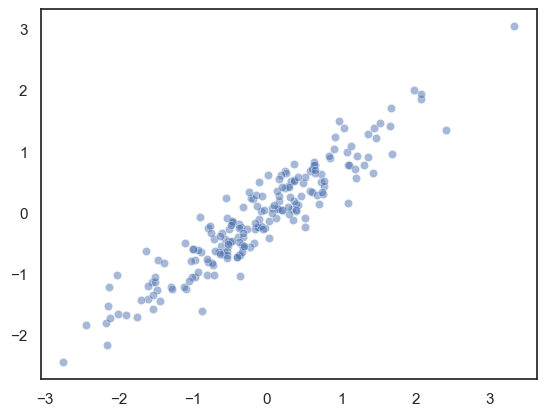

In [3]:
X = np.dot(rng.uniform(size=(2, 2)), rng.normal(size=(2, 200))).T
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.5);

By eye, it is clear that there is a nearly linear relationship between the *x* and *y* variables.
This is reminiscent of linear regression, but the problem setting here is slightly different: rather than attempting to *predict* the *y* values from the *x* values, the unsupervised learning problem attempts to learn about the *relationship* between the *x* and *y* values.

In principal components analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's `PCA` estimator, we can compute this as follows.

The fit learns some quantities from the data, most importantly the components and explained variance:

In [6]:
pca = PCA(n_components=2)
pca.fit(X)
print('Loadings:\n', pca.components_)
print('\nExplained Variance Ratio:\n', pca.explained_variance_ratio_)

Loadings:
 [[ 0.75611479  0.65443901]
 [-0.65443901  0.75611479]]

Explained Variance Ratio:
 [0.96932375 0.03067625]


To see what these numbers mean, let's visualise them as vectors over the input data, using the components to define the direction of the vector and the explained variance to define the squared length of the vector (see the following figure):

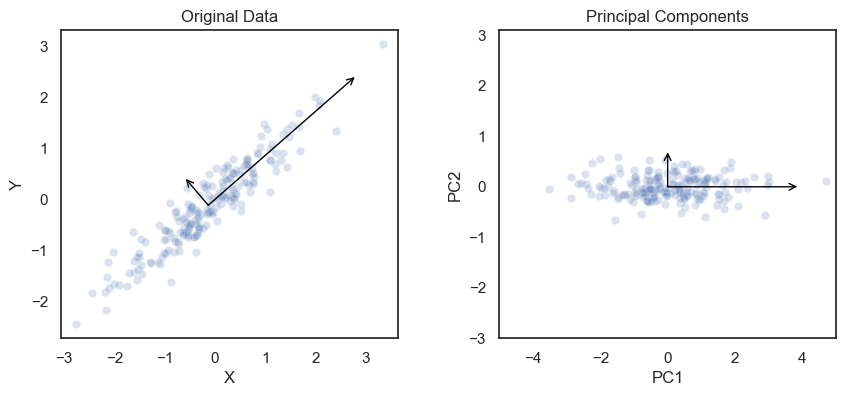

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops = {
        'arrowstyle': '->', 'linewidth': 1, 'color': 'black',
        'shrinkA': 0, 'shrinkB': 0,
    }
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)

# plot data
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.2, ax=ax[0])
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
# ax[0].axis('equal')
ax[0].set(xlabel='X', ylabel='Y', title='Original Data')

# plot principal components
X_pca = pca.transform(X)
ev = pca.explained_variance_
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.2, ax=ax[1])
draw_vector([0, 0], [3*np.sqrt(ev[0]), 0], ax=ax[1])
draw_vector([0, 0], [0, 3*np.sqrt(ev[1])], ax=ax[1])
ax[1].set(
    xlabel='PC1', ylabel='PC2',
    title='Principal Components',
    xlim=(-5, 5), ylim=(-3, 3.1)
);

These vectors represent the principal axes of the data, and the length of each vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the principal components of the data.

### PCA for Dimensionality Reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [5]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print(f'Original Shape: {X.shape}')
print(f'Transformed Shape: {X_pca.shape}')

Original Shape: (200, 2)
Transformed Shape: (200, 1)


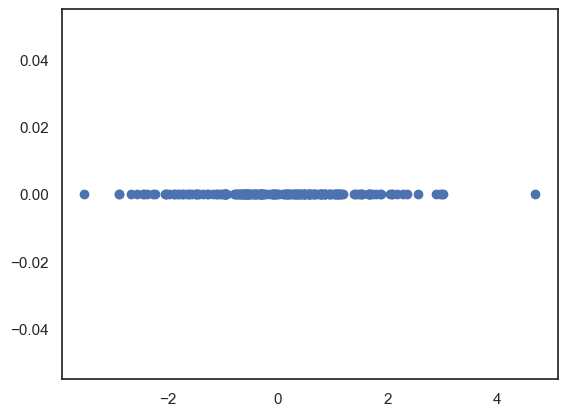

In [6]:
plt.scatter(x=X_pca, y=[0]*200);

The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data (see the following figure):

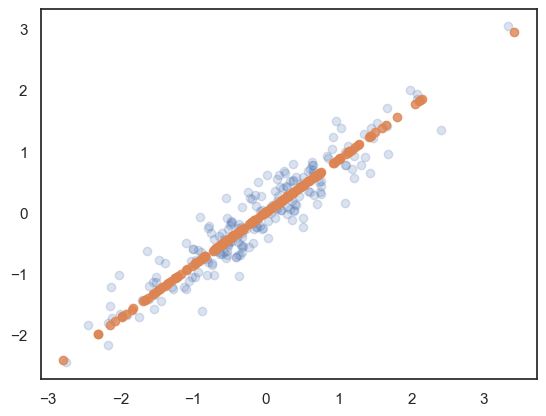

In [7]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8);

The blue points are the original data, while the orange points are the projected version.
This clarifies what a PCA is doing: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in the preceding figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the number of data features by 50%, the overall relationships between the data points are mostly preserved.

### Biplots: Adding Interpretability to Principal Components

Although PCA causes a loss in interpretability due to PCs being linear combinations of the original features, it is possible to retain *some* understanding on the variability of data with respect to each feature.

This is achieved through **biplots**, which present the transformed data, together with an overlay of the *loadings* vectors.

Lets first load and transform the `iris` data set:

In [8]:
iris = load_iris()
X = iris.data
y = iris.target
nu = len(np.unique(y))
pal = sns.color_palette('Set2', nu)
feats = [feat[:-5] for feat in iris['feature_names']]
y_names = pd.Series(y, name='Species').map({
    0: 'Setosa', 1: 'Versicolor', 2: 'Virginica',
})

# Scale the data prior to PCA
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Transform the data
pca = PCA()
X_pc = pca.fit_transform(X)

print(f'Explained Variance Ratios: {pca.explained_variance_ratio_[:2]}')

Explained Variance Ratios: [0.72962445 0.22850762]



As there is no built-in function for **biplots** in `sklearn`, we will need to define our own:

ValueError: array length 442 does not match index length 150

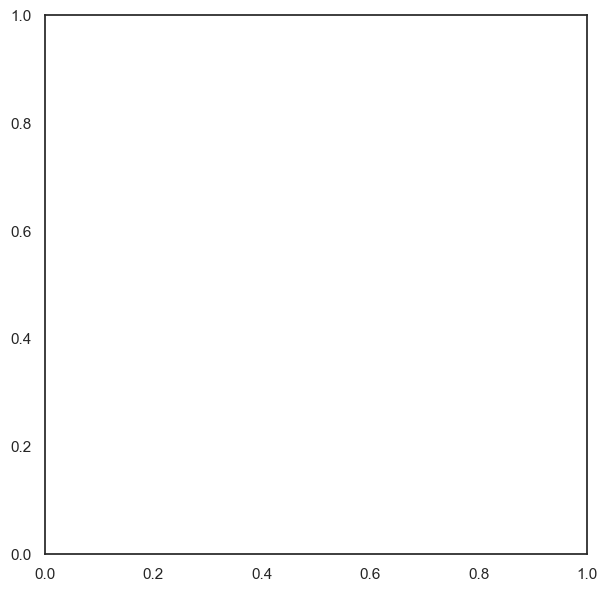

In [19]:
def biplot(X_pc, coeff, feats):
    xs = X_pc[:, 0]
    ys = X_pc[:, 1]
    n_feats = coeff.shape[0]
    pca2load, load2pca = lambda x: x/3, lambda x: x*3
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=xs, y=ys, hue=y_names, palette=pal)
    for i in range(n_feats):
        ax.arrow(
            0, 0, 3*coeff[i,0], 3*coeff[i,1], color='r',
            head_width=0.1, head_length=0.2, length_includes_head=True,
        )
        ax.text(
            3.1*coeff[i, 0], 3.1*coeff[i, 1], feats[i],
            color='r', ha='left', va='center',
        )
    ax.set(xlabel='PC1', ylabel='PC2')
    xsecax = ax.secondary_xaxis('top', functions=(pca2load, load2pca))
    ysecax = ax.secondary_yaxis('right', functions=(pca2load, load2pca))
    xsecax.set_xticks([-0.5, 0, 0.5])
    ysecax.set_yticks([-0.5, 0, 0.5])
    xsecax.set_xlabel('PC1 Loadings')
    ysecax.set_ylabel('PC2 Loadings', rotation=-90, va='bottom')
    ax.grid();

# Call the function. Use only the first 2 PCs.
biplot(X_pc[:, 0:2], pca.components_[0:2, :].T, feats)

From this plot we can see that:
- *Setosa* is smaller in `petal length`, `petal width`, and `sepal length` than the other two species
- *Virginica* is slightly higher for the same three features than the other two species
- `sepal width` distribution is high on PC2, but low on PC1, meaning that it is **not as relevant** in explaining the variance of the dataset. This can be confirmed by the **Explained Variance Ratios** for PC1 and PC2 (approx. 0.73 and 0.23, respectively)

## Example: Eigenfaces

We will be using the *Labeled Faces in the Wild* (LFW) dataset made available through Scikit-Learn to see how PCA may be used to reduce the dimensionality of data, yet be good enough to preserve information.

Lets first import the LFW data set:

In [9]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)
print(f'Pixels per image: {62*47}')

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
Pixels per image: 2914


- Let's take a look at the principal axes that span this dataset.
- Because this is a large dataset, we will use the `'randomized'` eigensolver in `PCA`: it uses a randomised method to approximate the first $N$ principal components more quickly than the standard approach, at the expense of some accuracy.
- This trade-off can be useful for high-dimensional data (in this case, nearly $3,000$ pixels per image).
- We will consider the first $150$ components:

In [10]:
pca = PCA(150, svd_solver='randomized', random_state=42)
pca.fit(faces.data)

PCA(n_components=150, random_state=42, svd_solver='randomized')

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as *eigenvectors*,
so these types of images are often called *eigenfaces*; as you can see in the following figure, they are as creepy as they sound):

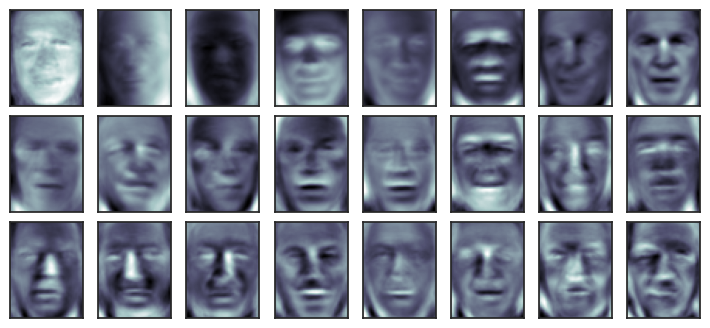

In [11]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw={'hspace':0.1, 'wspace':0.1})
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving (see the following figure):

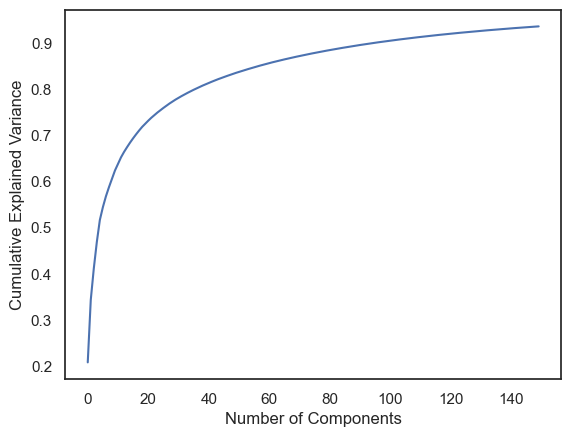

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

The 150 components we have chosen account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components (see the following figure):

In [13]:
# Compute the components and projected faces
pca = pca.fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

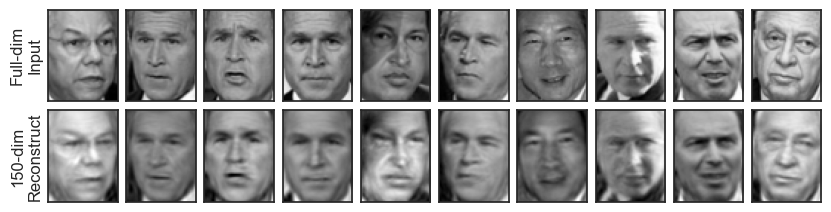

In [14]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('Full-dim\nInput')
ax[1, 0].set_ylabel('150-dim\nReconstruct');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
Although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in each image. This means a classification algorithm only needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which, depending on the particular algorithm we choose, can lead to much more efficient classification.

### Hands On

Try PCA on the **Diabetes** dataset, which may be loaded using sklearn's `load_diabetes` function. Generate a biplot for the first two components, and give an interpretation of what you see.

In [15]:
# load the dataset
diabetes = load_diabetes()

In [17]:

print(f'Feature Names: {diabetes.feature_names}')
print(f'Data Shape: {diabetes.data.shape}')
print(f'Target Shape: {diabetes.target.shape}')
print(diabetes.DESCR)

Feature Names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Data Shape: (442, 10)
Target Shape: (442,)
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibl

C:\Users\Computer Science\AppData\Local\Temp\ipykernel_18808\970281596.py:7: UserWarning: 
The palette list has fewer values (3) than needed (214) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=xs, y=ys, hue=y_names, palette=pal)


Explained Variance Ratios: [0.40242108 0.14923197]


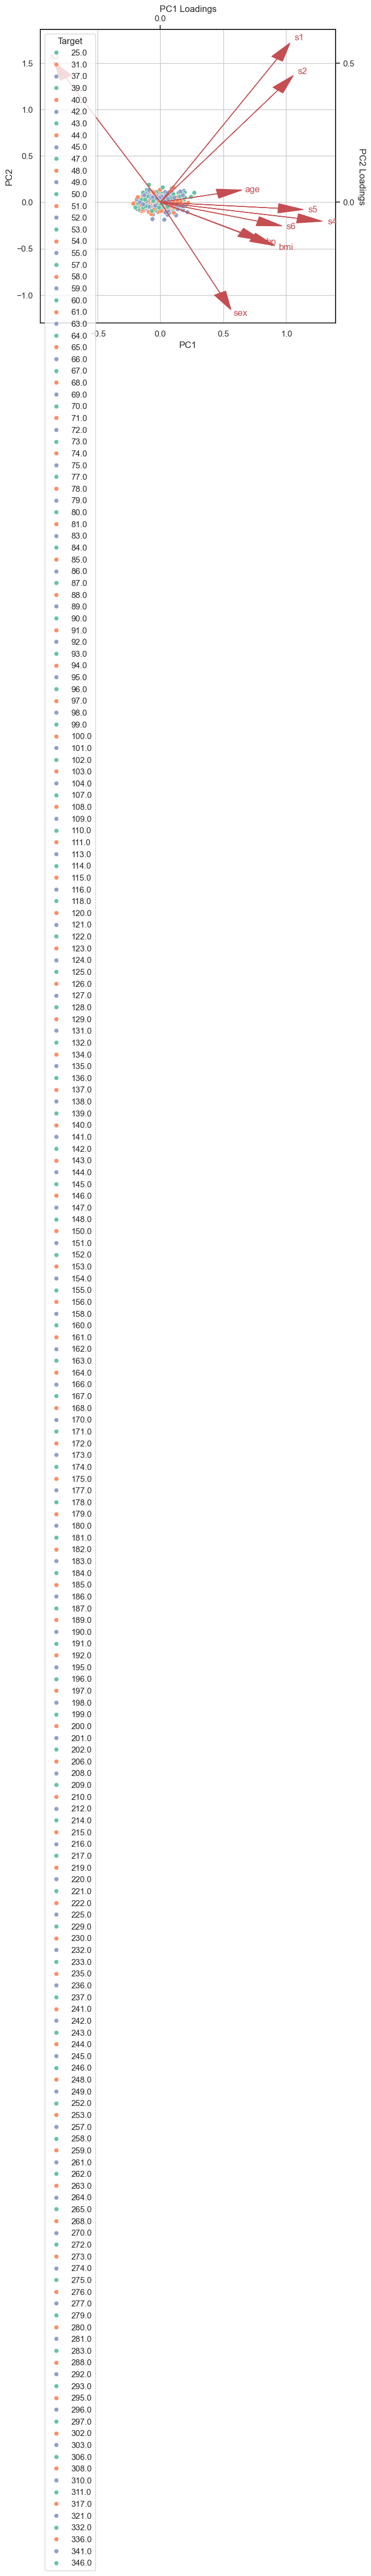

In [22]:
# pca = PCA(2)
# X = diabetes.data
# y = diabetes.target
# feats = diabetes.feature_names
# X_pc = pca.fit_transform(X)

# # Create a new y_names series for the diabetes dataset
# y_names = pd.Series(y, name='Target')

# biplot(X_pc, pca.components_.T, feats)
# print(f'Explained Variance Ratios: {pca.explained_variance_ratio_}')

pca = PCA(n_components=2)
X_pc = pca.fit_transform(X)

# Create a new y_names series for the diabetes dataset
y_names = pd.Series(y, name='Target')

biplot(X_pc, pca.components_.T, feats)
print(f'Explained Variance Ratios: {pca.explained_variance_ratio_}')


# K-Means Clustering

Let's create our own dataset for this section


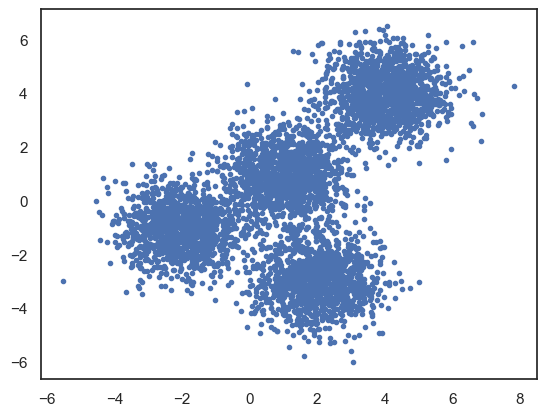

In [23]:
X, y = make_blobs(
    n_samples=5000,
    centers=[[4,4], [-2, -1], [2, -3], [1, 1]],
    cluster_std=0.9,
)

plt.scatter(X[:, 0], X[:, 1], marker='.');

<h2 id="setting_up_K_means">Setting up K-Means</h2>
Now that we have our random data, let's set up our K-Means Clustering.


The `KMeans` class has many parameters that can be used, but we will be using these two:

- **n_clusters**: The number of clusters to form as well as the number of centroids to generate. We will set this to $4$ (as we have 4 centers)
- **n_init**: Number of time the K-Means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. We will set this to $12$.

Initialize KMeans with these parameters, where the output parameter is called `k_means`, and fit the model to our data:


In [24]:
k_means = KMeans(n_clusters=4, n_init=12)
k_means.fit(X)

c:\Users\Computer Science\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Computer Science\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Computer Science\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Computer Science\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child

KMeans(n_clusters=4, n_init=12)

We can get the labels for each point in the model using K-Means' `labels_` attribute:


In [25]:
k_means.labels_

array([3, 2, 3, ..., 3, 3, 1])

We will also get the coordinates of the cluster centers using K-Means' `cluster_centers_` attribute:


In [26]:
k_means.cluster_centers_

array([[-2.02995059, -1.05071017],
       [ 3.99917836,  3.99593599],
       [ 2.00754295, -2.98835364],
       [ 1.03367011,  0.98656838]])

Now that we have the random data generated and the K-Means model initialised, let's plot them and see what it looks like:


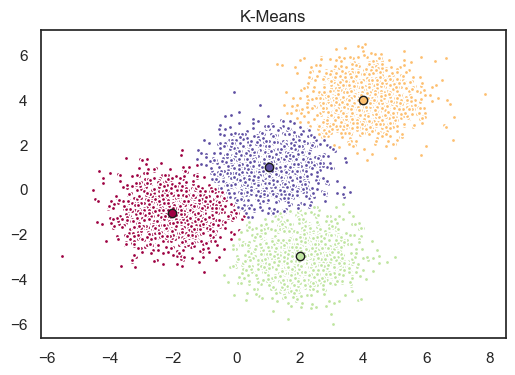

In [27]:
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means.labels_))))
ax = fig.add_subplot(1, 1, 1)

for k, col in enumerate(colors):
    clus = (k_means.labels_ == k)
    cluster_center = k_means.cluster_centers_[k]
    ax.plot(X[clus, 0], X[clus, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

ax.set_title('K-Means');

## Hands On

Try to cluster the above dataset into 3 clusters.

**Do not generate the data again**, use the same dataset as above.


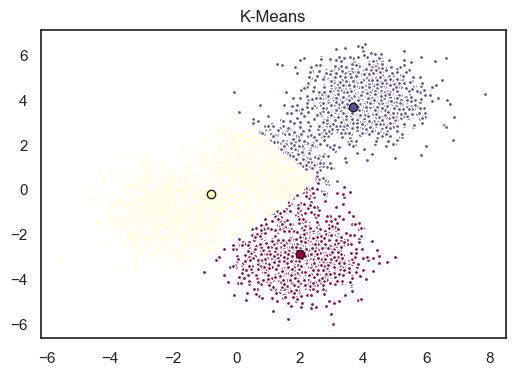

In [28]:
k_means = KMeans(n_clusters=3, n_init=12)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))
ax = fig.add_subplot(1, 1, 1)

for k, col in enumerate(colors):
    clus = (k_means_labels == k)
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[clus, 0], X[clus, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
    
ax.set_title('K-Means');


# DBSCAN

- We will now use DBSCAN, and compare it with K-Means and hierarchical clustering.
- Let's create a concentric circles data set, and see how well the different methods are able to find the right clusters:

In [29]:
def donut(r, n=100):
    return np.stack((
        np.cos(np.linspace(0, 2*np.pi, n, endpoint=False))*r,
        np.sin(np.linspace(0, 2*np.pi, n, endpoint=False))*r,
    ), axis=1) + rng.normal(-30, 30, size=(n, 2))

df1 = pd.DataFrame(donut(500, 1500))
df2 = pd.DataFrame(donut(300, 1000))
df3 = pd.DataFrame(donut(100, 500))
dfn = pd.DataFrame(rng.uniform(-650, 650, (250, 2)))
df = pd.concat([df1, df2, df3, dfn]).rename(columns={0: 'x1', 1: 'x2'})

df.head()

,x1,x2
0,422.024478,-13.121092
1,498.259312,-16.573844
2,505.436692,-55.893389
3,401.552764,-0.712443
4,434.054973,-31.414808


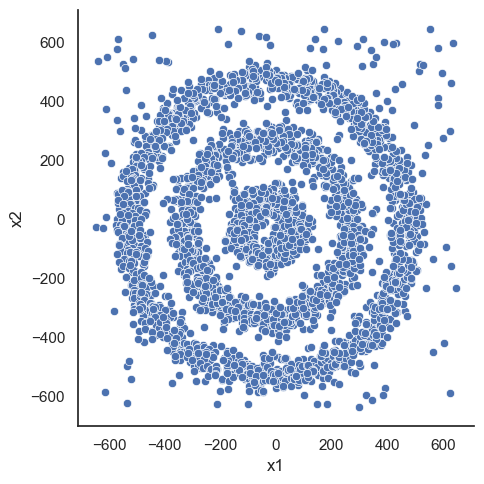

In [30]:
sns.relplot(data=df, x='x1', y='x2');

## K-Means vs Hierarchical vs DBSCAN

### K-Means

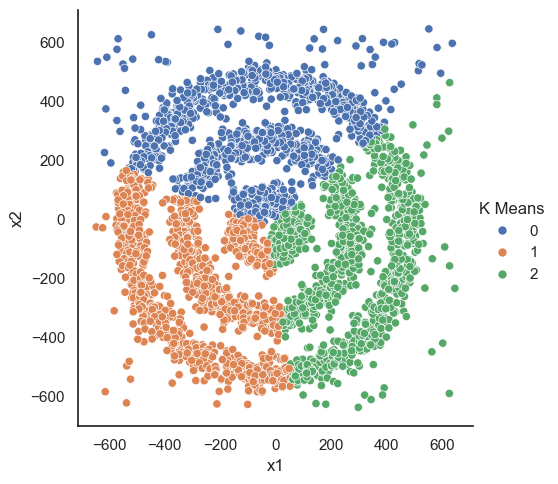

In [31]:
k_means=KMeans(n_clusters=3)
k_means.fit(df[['x1', 'x2']])
df['K Means'] = k_means.labels_
df['K Means'] = df['K Means'].astype('category')

sns.relplot(data=df, x='x1', y='x2', hue='K Means');

### Hierarchical Clustering

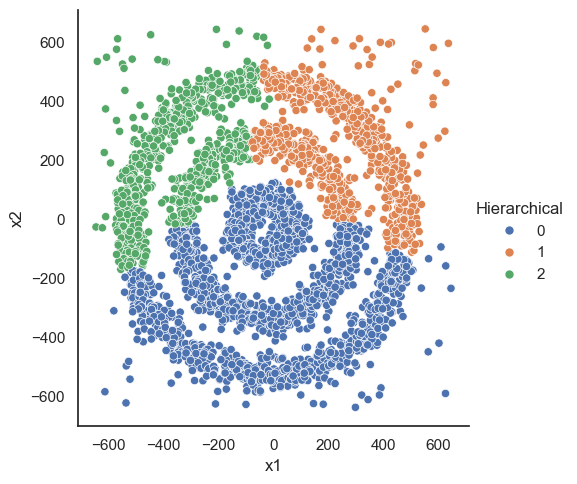

In [32]:
hier = AgglomerativeClustering(n_clusters=3, metric='euclidean')
hier.fit(df[['x1', 'x2']])
df['Hierarchical'] = hier.labels_
df['Hierarchical'] = df['Hierarchical'].astype('category')

sns.relplot(data=df, x='x1', y='x2', hue='Hierarchical');

### DBSCAN without tuning

Let's run DBSCAN on its default parameters: $ɛ = 0.5$ and `min_samples = 5`

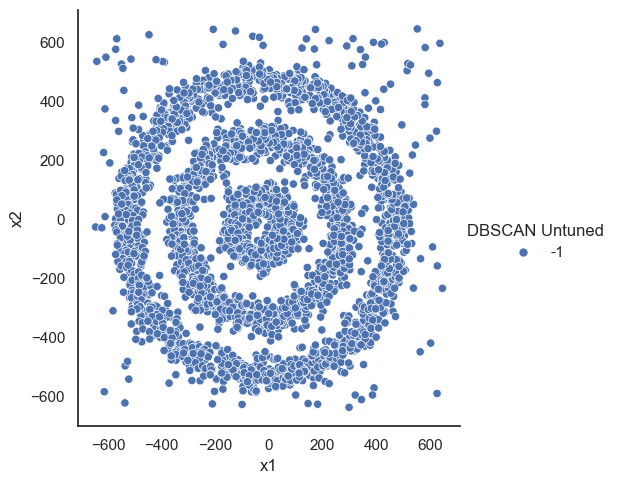

In [33]:
dbscan = DBSCAN()
dbscan.fit(df[['x1', 'x2']])
df['DBSCAN Untuned'] = dbscan.labels_
df['DBSCAN Untuned'] = df['DBSCAN Untuned'].astype('category')

sns.relplot(data=df, x='x1', y='x2', hue='DBSCAN Untuned');

DBSCAN does not seem to be working, as it is detecting just one cluster.

**This is happening because the default $ɛ$ is too small**.

The parameter `min_samples` is usually tuned using domain knowledge. For this example, `min_samples=6` works well.

To estimate $ɛ$, we need to plot the $(min\_samples - 1)$-distance graph, and find the **elbow** value:

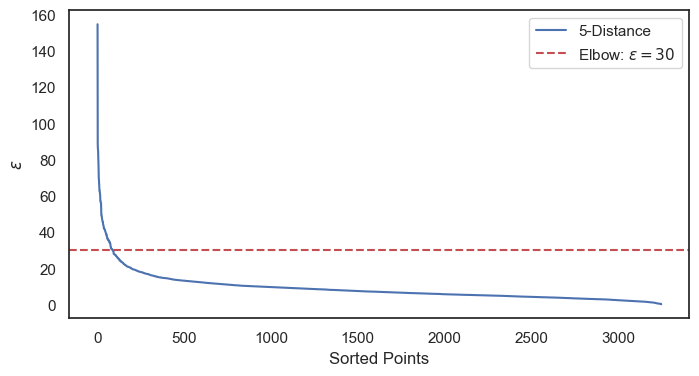

In [34]:
min_samples = 6
neigh = NearestNeighbors(n_neighbors=min_samples-1)
nbrs = neigh.fit(df[['x1', 'x2']])
distances, indices = nbrs.kneighbors(df[['x1', 'x2']])

# Plot the K-distance Graph
distances = np.sort(distances, axis=0)[::-1]
distances = distances[:, 1]

plt.figure(figsize=(8,4))
plt.plot(distances, label=f'{min_samples - 1}-Distance')
plt.axhline(y=30, color='r', linestyle='--', label=r'Elbow: $\varepsilon = 30$')
plt.xlabel('Sorted Points')
plt.ylabel(r'$\varepsilon$')
plt.legend();

The optimum $ɛ$ is found at the *elbow* in the K-Distance Graph, $ɛ = 30$

### Tuned DBSCAN

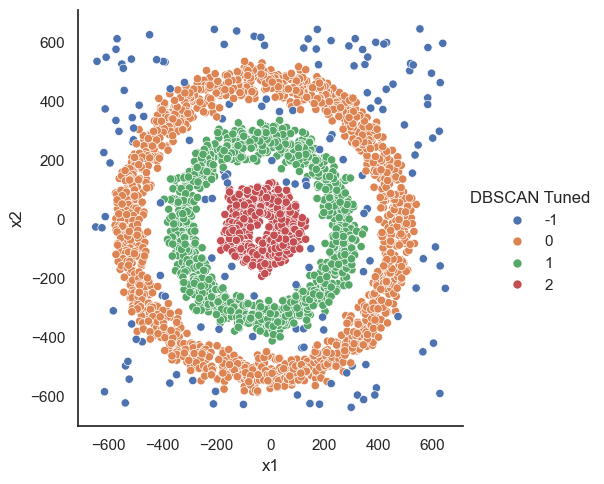

In [35]:
dbscan_opt = DBSCAN(eps=30, min_samples=6)
dbscan_opt.fit(df[['x1', 'x2']])
df['DBSCAN Tuned'] = dbscan_opt.labels_
df['DBSCAN Tuned'] = df['DBSCAN Tuned'].astype('category')

sns.relplot(data=df, x='x1', y='x2', hue='DBSCAN Tuned');

## Hands On

Try the different clustering methods on the `iris` dataset, and tune the necessary parameters to try and detect each species.

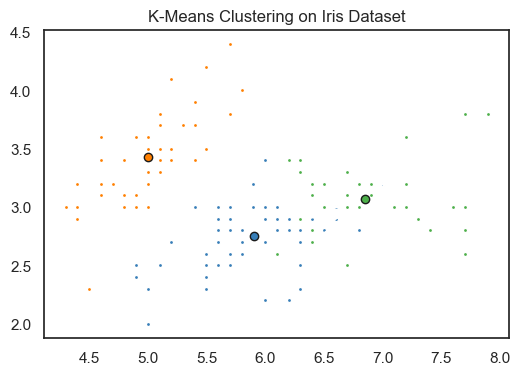

In [44]:
# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Perform K-Means clustering with tuning of parameters
k_means = KMeans(n_clusters=3, n_init=3)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

# Define custom colors
colors = ['#377eb8', '#ff7f00', '#4daf4a']

# Plot the results
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)

for k, col in enumerate(colors):
    clus = (k_means_labels == k)
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[clus, 0], X[clus, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

ax.set_title('K-Means Clustering on Iris Dataset');

Best Silhouette Score: 0.6867350732769776
Best Parameters: {'linkage': 'ward', 'n_clusters': 2}


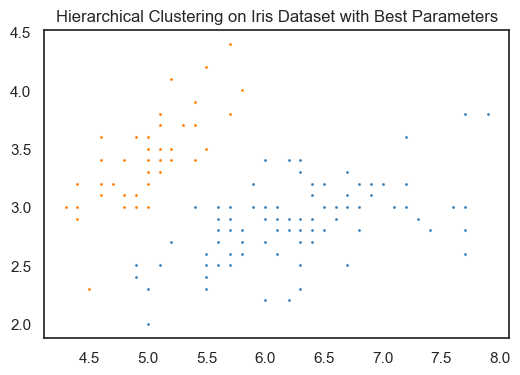

In [47]:
from sklearn.metrics import silhouette_score

# Define the range of parameters to test
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range = range(2, 6)

best_score = -1
best_params = {}

# Loop over different parameter values
for linkage in linkage_methods:
    for n_clusters in n_clusters_range:
        # Perform hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        hierarchical.fit(X)
        labels = hierarchical.labels_
        
        # Calculate the silhouette score
        score = silhouette_score(X, labels)
        
        # Update the best score and parameters if the current score is better
        if score > best_score:
            best_score = score
            best_params = {'linkage': linkage, 'n_clusters': n_clusters}

print(f'Best Silhouette Score: {best_score}')
print(f'Best Parameters: {best_params}')

# Plot the results with the best parameters
hierarchical = AgglomerativeClustering(n_clusters=best_params['n_clusters'], linkage=best_params['linkage'])
hierarchical.fit(X)
labels = hierarchical.labels_

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)

for k, col in enumerate(colors):
    clus = (labels == k)
    ax.plot(X[clus, 0], X[clus, 1], 'w', markerfacecolor=col, marker='.')

ax.set_title('Hierarchical Clustering on Iris Dataset with Best Parameters');

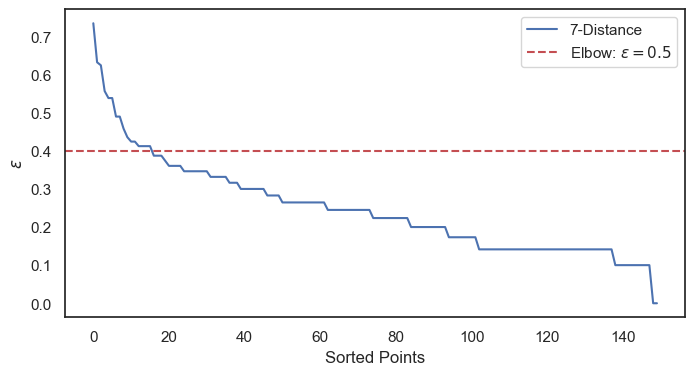

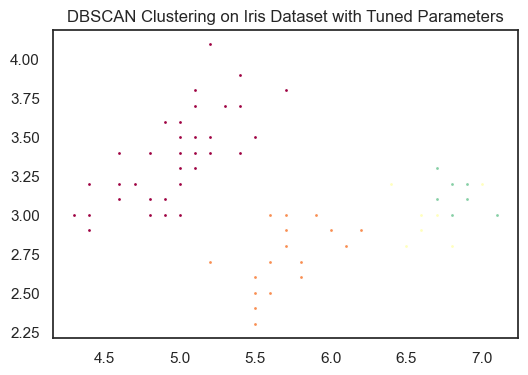

In [52]:
# Define the range of min_samples to test
min_samples = 8

# Fit the NearestNeighbors model
neigh = NearestNeighbors(n_neighbors=min_samples-1)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort the distances and plot the K-distance graph
distances = np.sort(distances, axis=0)[::- 1]
distances = distances[:, 1]
plt.figure(figsize=(8, 4))
plt.plot(distances, label=f'{min_samples - 1}-Distance')
plt.axhline(y=0.4, color='r', linestyle='--', label=r'Elbow: $\varepsilon = 0.5$')
plt.xlabel('Sorted Points')
plt.ylabel(r'$\varepsilon$')
plt.legend()
plt.show()

# Use the elbow value for eps
eps = 0.4

# Perform DBSCAN clustering with the tuned parameters
dbscan_opt = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_opt.fit(X)
labels = dbscan_opt.labels_

# Plot the results
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
ax = fig.add_subplot(1, 1, 1)

for k, col in enumerate(colors):
    clus = (labels == k)
    ax.plot(X[clus, 0], X[clus, 1], 'w', markerfacecolor=col, marker='.')
    
ax.set_title('DBSCAN Clustering on Iris Dataset with Tuned Parameters')
plt.show()